<img src="images/fig-main.png" width="1000">

In [15]:
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

<a href="https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04"> source1: what-is-a-transformer</a>

<a href="https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/"> source2: introduction-to-positional-encoding</a>

<a href="https://medium.com/@gautam.e/what-is-nn-embedding-really-de038baadd24"> source3: what-is-nn-embedding-really</a>

<a href="https://jalammar.github.io/illustrated-transformer/"> source4: illustrated-transformer</a>

# The Transformer

<table>   
  <tr>     
    <td><img src="images/fig-transformer-model-architectur.jpg" width="550"></td>     
    <td>
        <ol>
            <li>Novel architecture Introduced in the paper ‘<b>Attention Is All You Need</b>’</li>
            <li><b>sequence-to-sequence</b>: It is an architecture for transforming one sequence into another one with the help of two parts (Encoder and Decoder)</li>
            <li>It is an architecture with only <b>attention-mechanisms without any RNN</b> (Recurrent Neural Networks)</li>
            <li>Both Encoder and Decoder are composed of <b>modules</b> that can be stacked on top of each other multiple times (Nx) </li>
            <li>The inputs and outputs (target sentences) are first <b>embedded</b>, since we cannot use strings directly.</li>
        </ol> 
    </td>   
  </tr> 
</table>


### Pytorch code
<a href="https://github.com/SamLynnEvans/Transformer/tree/e06ae2810f119c75aa34585442872026875e6462">source code</a>

In [16]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

## Embedding and Encoding

![](images/fig-transformer-embedding.jpg)
<!-- <img src="images/fig-main.png" width="1000"> -->

## Embedding

<table>   
  <tr>     
    <td><img src="images/fig-embedding-matrix-mult.png" width="900"></td>  
    <td>
        <ol>
            <li>An embedding usually <b>maps</b> a given integer into an n-dimensional space</li>
            <li>An embedding is basically the same thing as a <b>linear layer</b> but works differently in that it does a lookup instead of a matrix-vector multiplication.</li>
        </ol> 
    </td>   
  </tr> 
</table>



In [17]:
# From: https://github.com/SamLynnEvans/Transformer
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding( , d_model)
    def forward(self, x):
        return self.embed(x)

SyntaxError: invalid syntax (142472628.py, line 6)

In [ ]:
embedder = Embedder(10, 8)
word_index = torch.tensor(1, dtype=torch.int)

embedder.embed.weight

In [ ]:
embedder(word_index)

### Note

* `self.embed` has one trainable parameter called `weight`, which is, by default, set **to be trained**. 
* You can check it by :</br>
  `embedder.embed.weight.requires_grad` </br>
  which returns True. 

In [ ]:
embedder.embed.weight.requires_grad 

* If you don't want to train your embeddings during model training (when you are using pre-trained embeddings),   you can set them to `False` by : </br>
  `embedder.embed.weight.requires_grad = False`


### Example: Embedding vs Linear


In [ ]:
vocab_size = 3
row = torch.tensor([1, 0, 0], dtype=torch.float) # one-hot vector for the first sample

### nn.Linear

In [ ]:
emb_len = 4
w_linear = nn.Linear(vocab_size, emb_len, bias=False)
w_linear.weight

In [ ]:
print(torch.matmul(row, w_linear.weight.T)) # embedding of the first sample
print(w_linear(row))                        # embedding of the first sample

### nn.Embedding

In [ ]:
# Pre-trained embedding, using the Linear layer weights (to obtain the same embedding)
w_embedding = nn.Embedding(vocab_size, emb_len).from_pretrained(w_linear.weight.T)
w_embedding.weight

In [18]:
emb0 = w_embedding(torch.tensor(0, dtype=torch.int))
print(emb0)

tensor([ 0.3406,  0.5289, -0.3270,  0.4561])


* The outputs are the same
* The linear layer _w\_linear_ does the actual **matrix vector multiplication**
* In contrast, _w\_embedding_ just needed the **indices** of row to **do a lookup**

### Exercise

Create the embedding vectors of the following sentences, using the `Embedder` class
* "Could The Transformer be another nail in the coffin for RNNs ?"
* "Convolutional neural networks have been widely used"

1. Print the embedding vector of the word "RNNs".
2. Print the embedding vectors of all the words in "RNNs neural networks Could be used".

In [38]:
from collections import Counter

# tokenize the sentence
words = ("Could The Transformer be another nail in the coffin for RNNs ? " + 
         "Convolutional neural networks have been widely used").split()
# create a dictionary of unique words
vocab = Counter(words) 
# map words to unique indices
word2idx = {word: ind for ind, word in enumerate(vocab.keys())} 
# transform words of sentences to indices
encoded_sentences = [word2idx[word] for word in words]

emb_dim = 4 
vocab_size = len(vocab)
embedder = Embedder(vocab_size, emb_dim)

print(embedder(torch.tensor(1)))
print(embedder(torch.LongTensor([0,1])))

# Print the embedding vector of the word "RNNs".
print("RNNs", embedder(torch.tensor(word2idx["RNNs"])))
# Print the embedding vectors of all the words in "RNNs neural networks Could be used".


tensor([ 1.2262,  0.3003,  0.1069, -0.6548], grad_fn=<EmbeddingBackward0>)
tensor([[-0.3292,  1.9294, -0.0744,  1.4484],
        [ 1.2262,  0.3003,  0.1069, -0.6548]], grad_fn=<EmbeddingBackward0>)
RNNs tensor([ 0.0250, -0.5581,  0.2050, -0.5986], grad_fn=<EmbeddingBackward0>)


## Positional encoding

* The Transformer architecture by itself **does not care about the actual order of words**, i.e. you could switch words as you like and the final result would stay the same. 
* To circumvent this _permutation invariance_, a tensor representing the position of each word and also the position of each scalar within the embedding is added to the actual embedding!
* Positional encoding is used to injects information about the `relative or absolute position` of the input sequence.
* The **Sinusoidal-based encoding** does not require training, thus does not add additional parameters to the model.
* The 1D positional encoding was first proposed in [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf). 

<img src="images/fig-positional-encoding-sentence.png" width="400">

### The idea 

<table>   
  <tr>     
    <td><img src="images/fig-positional-encoding.png" width="900"></td>  
    <td>
        <ol>
            <li>imagine for each value of the embedding vector a `sin/cos wave` with a specific frequency.</li>
            <li>In order to compute the embedding vector say `for 5th word`, you just read for each value of the embedding vector the value of its `sin/cos wave at position 5`.</li>
        </ol> 
    </td>   
  </tr> 
</table>

### The formula

* Suppose we have an input sequence of length $L$ and we require the position of the object $k^{th}$ within this sequence. 
* The positional encoding $P(k,j)$ is given by _sine_ and _cosine_ functions of varying frequencies:
$$P(k,2i)=\sin(\frac{k}{n^{2i/d}})$$
$$P(k,2i+1)=\cos(\frac{k}{n^{2(i+1)/d}})$$
Here:

* $k$: Position of an object in input sequence, $0\leq k<L$
* $d$: Dimension of the output embedding space
* $P(k,j)$: Position function for mapping a position $k$, in the input sequence, to index $(k,j)$ of the positional matrix
* $n$: User defined scalar. Set to 10,000 by the authors of [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf).
* $i$: Used for mapping to column indices $0\leq i<d/2$. A single value of $i$ maps to both _sine_ and _cosine_ functions

In the above expression we can see that `even` positions correspond to **sine** function and `odd` positions correspond to **cosine** function.

### Implementation in Pytorch

In [20]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 10, dropout = 0.1):
        """
        :param d_model: dimension of the model
        :param max_seq_len: length of positions
        :creates: [max_seq_len*d_model] position matrix
        """
        super().__init__()
        self.d_model = d_model
        if d_model % 2 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on pos and i
        self.pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                self.pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                self.pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        self.pe = self.pe.unsqueeze(0)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        # add constant to embedding x
        seq_len = x.size(1)
        pe = Variable(self.pe[:,:seq_len], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        return self.dropout(x)

In [21]:
num_positions = 100 # PE for "num_positions" data points
d_model = 32       # model dimension "d_model"

In [22]:
pos_enc = PositionalEncoder(d_model, max_seq_len=num_positions)
print("Positional encoding shape:", pos_enc.pe.shape)

Positional encoding shape: torch.Size([1, 100, 32])


#### even positions correspond to sine function

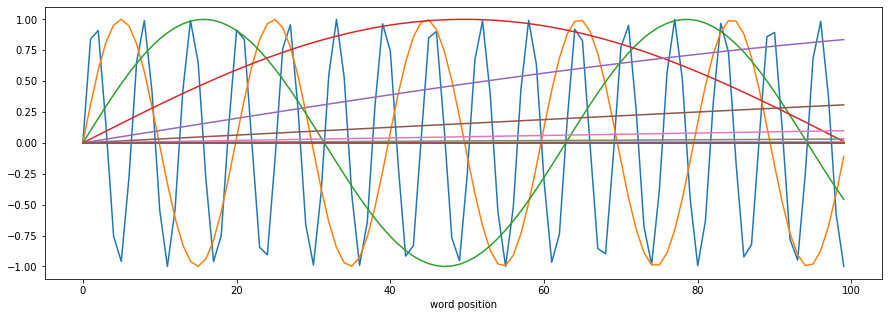

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(num_positions), pos_enc.pe[0,:,0::2].data.numpy());
plt.xlabel("word position");

#### odd positions correspond to cosine function

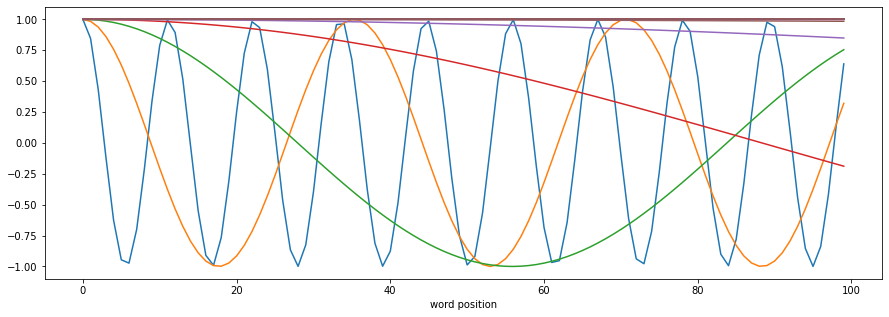

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(num_positions), pos_enc.pe[0,:,1::2].data.numpy());
plt.xlabel("word position");

### Visualizing the Positional Matrix

* Let’s visualize the positional matrix on bigger values. 
* We’ll use Python’s matshow() method from the matplotlib library. 

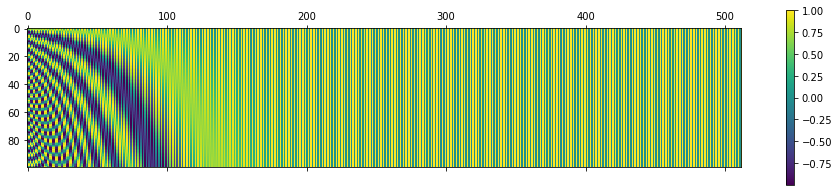

In [25]:
pos_enc = PositionalEncoder(d_model=512, max_seq_len=100)
pe = pos_enc.pe.squeeze(0)
cax = plt.matshow(pe);
plt.gcf().colorbar(cax);

### Understanding the Positional Encoding Matrix

To better understand positional coding, let's start by looking at the sine wave over a **continuous interval** for different positions with n=10,000 and d=512.
* We can see that each position corresponds to a different sinusoid, which `encodes a single position` into a vector. 

In [26]:
def plotSinusoid(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d)
    y = np.sin(k/denominator)
    plt.plot(x, y)
    plt.title('k = ' + str(k))
 
fig = plt.figure(figsize=(25, 4))    
for j in range(6):
    plt.subplot(161 + j)
    plotSinusoid(j*4)

## The Encoder

<table>   
  <tr>     
    <td><img src="images/fig-transformer-encoder.jpg" width="1000"></td>     
    <td>
        <ol>
            <li>The transformer uses an encoder-decoder architecture. </li>
            <li>The encoder extracts features from an input sentence, and the decoder uses the features to produce an output sentence (translation).</li>
            <li>The encoder in the transformer consists of multiple encoder blocks. An input sentence goes through the encoder blocks, and the output of the last encoder block becomes the input features to the decoder.</li>
            <li>The encoder uses “Nx” (N-times) to indicate multiple blocks.</li>
        </ol> 
    </td>   
  </tr> 
</table>


### Encoder implementation

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

### Normalization layer

In [28]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

### FeedForward layer

* Linear layer uses **matrix multiplication** to transform their input features into output features.
* When the input features are received by a Linear layer, they are received in the form of a flattened one-dimensional tensor and then multiplied by the weight matrix. 
* This matrix multiplication produces output features.
$$y=x*W+b$$


### FeedForward layer

<img src="images/fig-feedforward-layer.jpg" width="800">

In [29]:
in_features = torch.randn(4)
weight_matrix = torch.randn(3,4)
bias = torch.randn(3)

ff_out = weight_matrix.matmul(in_features) + bias
ff_out.shape

torch.Size([3])

### Generic linear layer example

In [30]:
in_features = torch.randn(3,5,6)
weight_matrix = torch.randn(6,8) # 6 input neurons and 8 output neurons
bias = torch.randn(8)

ff_out = in_features.matmul(weight_matrix) + bias
ff_out.shape

torch.Size([3, 5, 8])

### Transformer: FeedForward layer implementation

In [31]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
    
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

## MultiHeadAttention

<td><img src="images/fig-transformer-multiheadattention.jpg" width="1100"></td> 

### Scaled Dot-Product Attention

In [32]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

### Intro

<table>   
  <tr>     
    <td><img src="images/fig-multi-head-attention.png" width="1000"></td>     
    <td>
        <ol>
            <li>Transformer model was first introduced in the original paper named “Attention Is All You Need,” and from the title you can easily see that <b>attention mechanism plays important roles</b> in this model.</li>
            <li>Multi-Head Attention consists of <b>several attention layers</b> running in parallel</li>
            <li>“<font color='blue'>keys</font>” and “<font color='blue'>queries</font>” can be the <b>same sentence</b> in the <b>same language</b>, and in this case the resulting attentions are called <font color='red'>self-attentions</font>.</li>
            <li>You constantly care about what “she”, “it” , “the”, or “that” refers to in you own sentence, and we can say `self-attention is how these everyday processes is implemented`.</li>
            <li>In the previous figure of Transformer, there are <b>three multi-head attention</b>, which are displayed as boxes in orange. 
</li>
        </ol> 
    </td>   
  </tr> 
</table>

### Multi Head

<table  style="text-align:left"> 
  <tr>     
    <td><img src="images/fig-multi-head-attention.svg" width="1000"></td>     
    <td>
        <ol>
            <li>Given the same set of queries, keys and values, we might want our model to combine knowledge of different behaviors of the same attention mechanism.
</li>
            <li>For example, we want to know the dependencies of various intervals (eg Shorter interval vs. Longer interval) within a sequence.
</li>
            <li>Therefore, it may be useful to allow our attention mechanism to jointly use different subspaces of representation of queries, keys, and values.</li>
            <li>instead of performing a single attention pooling, queries, keys, and values can be transformed with $h$ independently learned linear projections.</li>
            <li>Then these $h$ projected queries, keys, and values are fed into attention pooling in parallel. </li>
            <li>In the end, $h$ attention pooling outputs are concatenated and transformed with another learned linear projection to produce the final output.</li>
        </ol> 
    </td>   
  </tr> 
</table>


### MultiHeadAttention model

Given a query $q$, a key $k$, and a value $v$, each attention head $h_i~(i=1,\dots,N)$ is computed as

$$h_i=f(W_i^{(q)}q, W_i^{(k)}k, W_i^{(v)}v)$$

where $W_i^{(q)}$, $W_i^{(k)}$, and $W_i^{(v)}$, are learnable parameters,
and $f$ is attention pooling, such as additive attention.

The <font color="blue">multi-head attention</font> output is another linear transformation via learnable parameters $W_0$ of the concatenation of $N$ heads:

$$W_0 \begin{bmatrix}
    h_1 \\
    h_2 \\
    \vdots \\
    h_N
\end{bmatrix}$$

We could say that the values in $v$ are multiplied and summed with some <font color="red">attention-weights</font> $a$, where our weights are defined by:

$$a=\text{softmax}(\frac{qk^T}{\sqrt{d_k}})$$

In this way, attention can be defined as:

$$\text{Attention}(q,k,v)=av$$

### MultiHeadAttention implementation

In [33]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        

        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)
    
        return output

### Self-Attention at a High Level

<table> 
  <tr>     
    <td><img src="images/fig-transformer_self-attention_visualization.png" width="800"></td>     
    <td>
        <ol>
            <li>Say the following sentence is an input sentence we want to translate:</br>
            ”<font color="red">The animal didn't cross the street because it was too tired</font>”</li>
            <li>What does “<b>it</b>” in this sentence refer to? Is it referring to the street or to the animal? It’s a simple question to a human, but not as simple to an algorithm.</li>
            <li>When the model is processing the word “<b>it</b>”, self-attention allows it to associate “<b>it</b>” with “<b>animal</b>”.</li>
            <li>As the model processes each word (each position in the input sequence), self attention allows it to look at other positions in the input sequence for clues that can help lead to a better encoding for this word.</li>
        </ol> 
    </td>   
  </tr> 
</table>

<a href="https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb">Tensor2Tensor notebook</a> where you can load a Transformer model, and examine it using this interactive visualization.

<a href="https://github.com/jessevig/bertviz/blob/master/README.md">bertviz</a> where you can load a model, and examine it.

### Multihead Attention visual explanation

There are three hyperparameters that determine the data dimensions:
<table> 
  <tr>     
    <td><img src="images/fig-multihead-att_visual-explanation.png" width="3000"></td>     
    <td>
        <ol>
            <li><b>Embedding Size</b> — width of the embedding vector (we use a width of 6 in our example). This dimension is carried forward throughout the Transformer model and hence is sometimes referred to by other names like ‘model size’ etc.</li>
            <li><b>Query Size</b> (equal to Key and Value size)— the size of the weights used by three Linear layers to produce the Query, Key, and Value matrices respectively (we use a Query size of 3 in our example)</li>
            <li><b>Number of Attention heads</b> (we use 2 heads in our example)</li>
        </ol> 
        In addition, we also have the Batch size, giving us one dimension for the number of samples.
    </td>   
  </tr> 
</table>

<a href="https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853">transformers-explained-visually</a>


### Understand from numbers

In [34]:
heads = 2
d_model = 6
bs=1
ma = MultiHeadAttention(heads, d_model)
sentence_len = 4
x = torch.rand(bs, sentence_len, d_model)
print("Input:", x.shape)
print("MultiHeadAttention output:", ma(x,x,x).shape)
print("q linear:", ma.q_linear(x).shape, "--> [batch, seq, emb]")
# print("k linear:", ma.k_linear(x).shape)
# print("v linear:", ma.v_linear(x).shape)
q = ma.q_linear(x).view(bs, -1, ma.h, ma.d_k).transpose(1,2)
k = ma.k_linear(x).view(bs, -1, ma.h, ma.d_k).transpose(1,2)
v = ma.v_linear(x).view(bs, -1, ma.h, ma.d_k).transpose(1,2)
print("q linear multi-heads:", q.shape, "--> [batch, heads, seq, q size]")
# print("k linear multi-heads:", k.shape)
# print("v linear multi-heads:", v.shape)

scores = F.softmax(torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(ma.d_k), dim=-1)
print("Scores(q, k):", scores.shape)
scores = torch.matmul(scores, v)
print("MH Attention(scores, v):", scores.shape)
concat = scores.transpose(1,2).contiguous().view(bs, -1, d_model)
print("Heads concatenation:", concat.shape)
output = ma.out(concat)
print("MultiHead Attention:", output.shape)

Input: torch.Size([1, 4, 6])
MultiHeadAttention output: torch.Size([1, 4, 6])
q linear: torch.Size([1, 4, 6]) --> [batch, seq, emb]
q linear multi-heads: torch.Size([1, 2, 4, 3]) --> [batch, heads, seq, q size]
Scores(q, k): torch.Size([1, 2, 4, 4])
MH Attention(scores, v): torch.Size([1, 2, 4, 3])
Heads concatenation: torch.Size([1, 4, 6])
MultiHead Attention: torch.Size([1, 4, 6])


## The Decoder

<table>   
  <tr>     
    <td><img src="images/fig-transformer-decoder.png" width="600"></td>     
    <td>
        <ol>
            <li>The <b>decoder</b> share some components with the **encoder** but they are used in a different way to take into account the encoder output</li>
            <li>$N=6$ identical layers, containing 3 sub-layers.</li>
            <ol>
                <li>the <b>Masked Multi-head attention</b> to prevent positions from attending to subsequent positions.  </li>
                <li><b>encoder-decoder attention</b> performs multi-head attention over the output of the decoder, the <b>Key</b> and <b>Value</b> vectors come from the output of the encoder but the <b>queries</b> come from the previous decoder layer </li>
                <li>finally the <b>fully-connected</b> network. </li>
            </ol>
            <li>At the end of the N stacked decoders, the <b>linear layer</b>, transforms the stacked outputs to a much larger vector, the <b>logits</b></li>
            <li>“The <b>softmax layer</b> then turns those scores (logits) into probabilities (all positive, all add up to 1.0) </li>       
        </ol> 
    </td>   
  </tr> 
</table>


### The Decoder in pytorch
<a href="https://github.com/SamLynnEvans/Transformer/tree/e06ae2810f119c75aa34585442872026875e6462">source code</a>

In [35]:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [36]:
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, \
        src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

## Training the Transformer for translation tasks

<table> 
  <tr>     
    <td><img src="images/fig-encoder_decoder_trainig-step.png" width="800"></td>     
    <td>
        <ol>
            <li>We know that to train a model for translation tasks we need <font color="blue">two sentences in different languages</font> that are translations of each other. </li>
            <li>Once we have a lot of sentence pairs, we can start training our model.</li>
            <li>Let’s say we want to translate French to English. </li>
            <li>Our <font color="blue">encoded</font> input will be a French sentence and the input for the <font color="blue">decoder</font> will be an English sentence. </li>
            <li>However, <font color="red">the decoder input will be shifted to the right by one position... </font>but, why?</li>
        </ol> 
    </td>   
  </tr> 
</table>


## Training: why we shift the decoder's input

* One reason is that we do **not** want our model to <font color="red">learn how to copy our decoder input</font> during training, 
* but we want to learn that 
  * given the **encoder** sequence and 
  * a particular **decoder** sequence, which has been already seen by the model, 
  * we <font color="red">predict the next word</font>.

### Training: an example

Problem: we want to transform `How are you <EOS>` in `<Start> I am fine <EOS>`
*    The source sequence would be `How are you <EOS>` 
*    The **input** to the **encoder** would be `How are you <EOS>`
*    The **target** sequence would be `I am fine <EOS>` . The output of the **decoder** will be compared against this in the training.
*    The **input** to the **decoder** would be `<start> I am fine`.

Notice that the input to the decoder is the target sequence shifted one position to the right by the token that signals the beginning of the sentence.

**The logic of this**
If we don’t shift the decoder sequence, the model learns to simply ‘`copy`’ the decoder input, since the target word for position $i$ would be the word $i$ in the decoder input. 

Thus, by **shifting the decoder input** by one position, our **model needs to predict** the target word for position $i$ having only seen the word $1, \dots, i-1$ in the decoder sequence.

### The Inference process

**Inferring** with Transformer **is different from the training**, which makes sense because in the end we want (for example) to translate a sentence without having the target sentence. 

**The trick** here is to <font color="red">re-feed</font> our model for each position of the output sequence until we come across an `end-of-sentence` token.

A more step by step method would be:

*    Input the full **encoder** sequence (French sentence) and as **decoder** input, we take an <font color="red">empty sequence</font> with only a start-of-sentence token on the first position.  This will **output** a sequence where we will only take the <font color="red">first element</font>.
*    That element will be filled into second position of our **decoder** input sequence, which now has a start-of-sentence token and a first word in it.
*    Input both the encoder sequence and the new decoder sequence into the model. Take the <font color="red">second element</font> of the output and put it into the decoder input sequence.
*    **Repeat this until** you predict an `end-of-sentence` token, which marks the end of the translation.

<a href="https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04">what-is-a-transformer</a>


![](images/fig-transformer-paper-results.png)

# Problems and state-of-the-art models

* On [this page](https://paperswithcode.com/methods/category/transformers) you will find  a continuously updated list of **Transformer neural networks**.
* On [this other page](https://paperswithcode.com/area/natural-language-processing) you will find a list of very active **natural language processing (NLP)** where deep learning gets the best results.


![](images/fig-nlp-tasks.png)
